In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import sklearn.metrics as m
# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
input_path = "../data/features_encoded.csv"
raw_data = pd.read_csv(input_path, header=0, skiprows=None, index_col=None, delimiter=",")

labels = raw_data['malicious'].apply(lambda x: 1 if x else 0)
features = raw_data.drop('malicious', axis=1)

train_features = features.iloc[:80000, :]
test_features = features.iloc[80000:, :]
train_labels = labels[:80000]
test_labels = labels[80000:]

In [3]:
def calculateNormalizationParams(data):
    means = data.mean()
    stdevs = data.std()
    stdevs[stdevs == 0] = 1  # Replace 0 std to avoid division by zero
    return means, stdevs

def applyNormalization(data, means, stdevs):
    return (data - means) / stdevs

In [4]:
means, stdevs = calculateNormalizationParams(train_features)
normalizedTrainFeatures = applyNormalization(train_features, means, stdevs)
normalizedTestFeatures = applyNormalization(test_features, means, stdevs)

In [6]:
best_k = 2
best_classifier = minibatch_kmeans = MiniBatchKMeans(n_clusters=best_k,max_iter=10,init="random").fit(normalizedTrainFeatures)
prev_error = best_classifier.inertia_

In [8]:
def clusteringScore(data, k):
    global best_k,best_classifier,prev_error
    minbatch_kmeans = MiniBatchKMeans(n_clusters=k, max_iter=10, init="random").fit(data)
    error = minibatch_kmeans.inertia_
    if(error < prev_error):
        prev_error = error
        best_classifier = minibatch_kmeans
        best_k = k
    return (k,minibatch_kmeans.inertia_)

In [9]:
k_vector = [2, 5, 10, 20,30,40,50,60,70,80,90,100]
scores = [clusteringScore(normalizedTrainFeatures, k) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, WSSSE = %d" %(score[0], score[1]))

k =   2, WSSSE = 885078
k =   5, WSSSE = 885078
k =  10, WSSSE = 885078
k =  20, WSSSE = 885078
k =  30, WSSSE = 885078
k =  40, WSSSE = 885078
k =  50, WSSSE = 885078
k =  60, WSSSE = 885078
k =  70, WSSSE = 885078
k =  80, WSSSE = 885078
k =  90, WSSSE = 885078
k = 100, WSSSE = 885078


In [10]:
minibatch_kmeans = best_classifier

In [29]:
predictions = minibatch_kmeans.predict(normalizedTestFeatures)

In [30]:
print("Inertia:", minibatch_kmeans.inertia_)

Inertia: 885078.5407959688


In [31]:
pred2label = {}
for i in range(0,len(predictions)):
    if not str(predictions[i]) in pred2label:
        pred2label.update({str(predictions[i]):{str(test_labels.iloc[i]):1}})
    elif not str(test_labels.iloc[i]) in pred2label[str(predictions[i])]:
        pred2label[str(predictions[i])].update({str(test_labels.iloc[i]):1})
    else:
        cur = int(pred2label[str(predictions[i])][str(test_labels.iloc[i])])
        pred2label[str(predictions[i])][str(test_labels.iloc[i])] = str(cur + 1)
for cluster in pred2label:
    bcount = int(pred2label[cluster]["0"]) if "0" in pred2label[cluster] else 0
    mcount = int(pred2label[cluster]["1"]) if "1" in pred2label[cluster] else 0
    if bcount > mcount:
        pred2label[cluster]["probability"] = float(bcount)/float(bcount+mcount)
    else:
        pred2label[cluster]["probability"] = float(mcount)/float(bcount+mcount)

In [32]:
def getProb(x):
    return pred2label[str(x)]["probability"]
probs = [getProb(x) for x in predictions]

In [33]:
if normalizedTrainFeatures.shape[1] in [2, 3]:
    plt.scatter(normalizedTrainFeatures[:, 0], normalizedTrainFeatures[:, 1], c=train_cluster_labels, cmap='viridis')
    centers = minibatch_kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.title("MiniBatch KMeans Clustering Visualization")
    plt.show()

In [25]:
homogeneity = m.homogeneity_score(test_labels,predictions)
completeness = m.completeness_score(test_labels,predictions)
v_measure = m.v_measure_score(test_labels,predictions)
print("Homogeneity score: " + str(homogeneity))
print("Completeness score: " + str(completeness))
print("V-Measure score: " + str(v_measure))

Homogeneity score: 1.4844799238725588e-05
Completeness score: 1.6266311760653493e-05
V-Measure score: 1.552307999841223e-05


In [34]:
acc = m.accuracy_score(test_labels, predictions)
prec = m.precision_score(test_labels, predictions)
recall = m.recall_score(test_labels, predictions)
f1 = m.f1_score(test_labels,predictions)
auc = m.roc_auc_score(test_labels,probs)
print("Accuracy score: " + str(acc))
print("Precision score: " + str(prec))
print("Recall score: " + str(recall))
print("F1 score: ", f1)
print("AUC-ROC: ", auc)

Accuracy score: 0.5413729313534323
Precision score: 0.4029948987987494
Recall score: 0.3063547660745559
F1 score:  0.34809182005543315
AUC-ROC:  0.49790115448250216


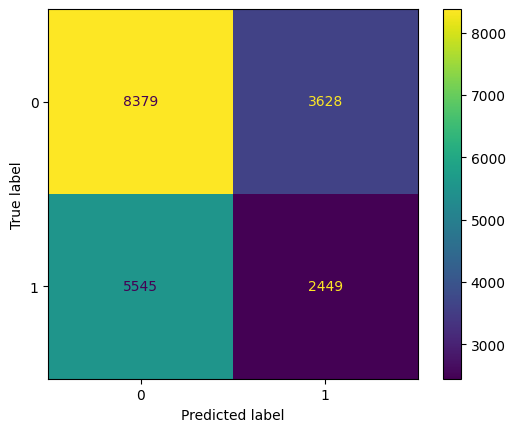

In [35]:
m.ConfusionMatrixDisplay(m.confusion_matrix(test_labels, predictions)).plot()

In [28]:
import pickle
with open('trained_models/minibatch_kmeans.pkl','wb') as f:
    pickle.dump(minibatch_kmeans,f)
print("Model dump complete!")

Model dump complete!
